In [1]:
%load_ext autoreload

In [2]:
import lightning.pytorch as pl
import torch
import pandas as pd
import os
import scanpy as sc
import seaborn as sns
import anndata
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [3]:
%autoreload 2
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.tester.reconstruction.test import eval_rec, test_pretrained_model, test_models_on_ood

In [4]:
DATA_PATH = '/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p'  # this is a shared directory in which the data is stored
MODEL_PATH = '/lustre/groups/ml01/workspace/till.richter/trained_models/'
RESULT_PATH = '/lustre/groups/ml01/workspace/till.richter/ssl_results'
HVG = False

In [5]:
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Set the colorblind friendly palette
sns.set_theme(style="whitegrid")

sns.set_palette("colorblind")

# Get the list of colors in the palette
palette_colors = sns.color_palette("colorblind")

# Access the colors
color_supervised = palette_colors[0]  # First color
color_ssl = palette_colors[1]  # Second color
color_zeroshot = palette_colors[2]  # Third color
color_baseline = palette_colors[3]  # Forth color, ([3] looks similar to [0])
color_else1 = palette_colors[5]
color_else2 = palette_colors[6]
color_else3 = palette_colors[7]

# Load Results

In [6]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)

df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
5,CN_MLP_50p,0.155226,0.252466,0.139534
6,CN_MLP_50prun1,0.152973,0.251865,0.139680
7,CN_MLP_50prun2,0.152813,0.251179,0.139711
8,CN_MLP_50prun3,0.152603,0.250942,0.139777
9,CN_MLP_50prun4,0.153601,0.252154,0.139637
10,CN_MLP_gene_program_C8_25p,-11.081179,0.195617,0.196073
12,CN_MLP_gp_to_tf,0.166528,0.263958,0.137646
13,CN_MLP_gp_to_tfrun1,0.165292,0.263478,0.137709
14,CN_MLP_gp_to_tfrun2,0.165126,0.263380,0.137703
15,CN_MLP_gp_to_tfrun3,0.165653,0.263416,0.137735


In [7]:
models_to_select = [
                    ### Only pretrained models ###
    
                    # Random Mask
                    'CN_NegBin_50prun0',  # Median Run
                    # Gene Program Masek
                    # TO DO
                    # GP to GP
                    'CN_NegBin_single_gene_programrun0',
                    # GP to TF
                    'CN_NegBin_gp_to_tfrun3',  # Median Run
    
                    ### Supervised model ###
    
                    'CN_No_SSL_CN_run1NegBin_',  # Median Run
    
                    ### Self-Supervised models ###
    
                    # Random Mask
                    'CN_SSL_CN_CN_MLP_50prun0NegBin_',
                    # Gene Program Mask
                    'CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_',
                    # GP to GP
                    'CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_',
                    # GP to TF
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',  # Median run
                    # BYOL
                    # TO DO
                    # Barlow Twins
                    # TO DO
    
                    ### Random ###
                    # 'Random',
                   ]

df = df[df['experiment'].isin(models_to_select)]
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
37,CN_NegBin_50prun0,0.166044,0.366818,0.102326
42,CN_NegBin_gp_to_tfrun3,0.188583,0.383413,0.099498
53,CN_NegBin_single_gene_programrun0,0.187824,0.383398,0.099499
33,CN_No_SSL_CN_run1NegBin_,0.180600,0.378120,0.100453
54,CN_SSL_CN_CN_MLP_50prun0NegBin_,0.180959,0.377217,0.100699
55,CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_,0.178291,0.377176,0.100627
56,CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_,0.182529,0.377372,0.100606
48,CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_,0.180490,0.379778,0.100167


In [8]:
"""
models_to_select = ['CN_No_SSL_CN_MLPrun2', 
                    'CN_MLP_50prun1', 
                    'CN_MLP_gene_program_C8_25p', 
                    'CN_MLP_gp_to_tfrun3',
                    'CN_MLP_single_gene_program',
                    'CN_No_SSL_CN_MLPrun2',
                    'CN_SSL_CN_CN_MLP_50prun0',
                    'CN_SSL_CN_CN_MLP_gene_program_C8_25prun0',
                    'CN_SSL_CN_CN_MLP_single_gene_programrun0',
                    'CN_SSL_CN_CN_MLP_gp_to_tfrun4',
                    'CN_SSL_CN_MLP_BYOL_Gaussian_0_001run0',
                    'CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0',
                   ]

df = df[df['experiment'].isin(models_to_select)]
df
"""

"\nmodels_to_select = ['CN_No_SSL_CN_MLPrun2', \n                    'CN_MLP_50prun1', \n                    'CN_MLP_gene_program_C8_25p', \n                    'CN_MLP_gp_to_tfrun3',\n                    'CN_MLP_single_gene_program',\n                    'CN_No_SSL_CN_MLPrun2',\n                    'CN_SSL_CN_CN_MLP_50prun0',\n                    'CN_SSL_CN_CN_MLP_gene_program_C8_25prun0',\n                    'CN_SSL_CN_CN_MLP_single_gene_programrun0',\n                    'CN_SSL_CN_CN_MLP_gp_to_tfrun4',\n                    'CN_SSL_CN_MLP_BYOL_Gaussian_0_001run0',\n                    'CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0',\n                   ]\n\ndf = df[df['experiment'].isin(models_to_select)]\ndf\n"

In [9]:
"""
custom_model_names = {
    'CN_MLP_50prun1': 'Zero-Shot\nRandom Mask',
    'CN_MLP_gene_program_C8_25p': 'Zero-Shot\nGP Mask',
    'CN_MLP_gp_to_tfrun3': 'Zero-Shot\nGP to TF',
    'CN_MLP_single_gene_program': 'Zero-Shot\nGP to GP',
    'CN_No_SSL_CN_MLPrun2': 'Supervised',
    'CN_SSL_CN_CN_MLP_50prun0': 'Self-Supervised\nRandom Mask',
    'CN_SSL_CN_CN_MLP_gene_program_C8_25prun0': 'Self-Supervised\nGP Mask',
    'CN_SSL_CN_CN_MLP_gp_to_tfrun4': 'Self-Supervised\nGP to TF',
    'CN_SSL_CN_CN_MLP_single_gene_programrun0': 'Self-Supervised\nGP to GP',
    'CN_SSL_CN_MLP_BYOL_Gaussian_0_001run0': 'Self-Supervised\nBYOL',
    'CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0': 'Self-Supervised\nBarlow Twins',
}

df['experiment'] = df['experiment'].apply(lambda x: custom_model_names.get(x, x))
df
"""

custom_model_names = {
    'CN_NegBin_50prun0': 'Zero-Shot\nRandom Mask',
    # 'CN_MLP_gene_program_C8_25p': 'Zero-Shot\nGP Mask',
    'CN_NegBin_gp_to_tfrun3': 'Zero-Shot\nGP to TF',
    'CN_NegBin_single_gene_programrun0': 'Zero-Shot\nGP to GP',
    'CN_No_SSL_CN_run1NegBin_': 'Supervised',
    'CN_SSL_CN_CN_MLP_50prun0NegBin_': 'Self-Supervised\nRandom Mask',
    'CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_': 'Self-Supervised\nGP Mask',
    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_': 'Self-Supervised\nGP to TF',
    'CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_': 'Self-Supervised\nGP to GP',
    # 'CN_SSL_CN_MLP_BYOL_Gaussian_0_001run0': 'Self-Supervised\nBYOL',
    # 'CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0': 'Self-Supervised\nBarlow Twins',
}

df['experiment'] = df['experiment'].apply(lambda x: custom_model_names.get(x, x))
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
37,Zero-Shot\nRandom Mask,0.166044,0.366818,0.102326
42,Zero-Shot\nGP to TF,0.188583,0.383413,0.099498
53,Zero-Shot\nGP to GP,0.187824,0.383398,0.099499
33,Supervised,0.180600,0.378120,0.100453
54,Self-Supervised\nRandom Mask,0.180959,0.377217,0.100699
55,Self-Supervised\nGP Mask,0.178291,0.377176,0.100627
56,Self-Supervised\nGP to GP,0.182529,0.377372,0.100606
48,Self-Supervised\nGP to TF,0.180490,0.379778,0.100167


In [10]:
# Remove the outliers
outliers = ['Zero-Shot\nGP Mask']
df = df[~df['experiment'].isin(outliers)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
37,Zero-Shot\nRandom Mask,0.166044,0.366818,0.102326
42,Zero-Shot\nGP to TF,0.188583,0.383413,0.099498
53,Zero-Shot\nGP to GP,0.187824,0.383398,0.099499
33,Supervised,0.180600,0.378120,0.100453
54,Self-Supervised\nRandom Mask,0.180959,0.377217,0.100699
55,Self-Supervised\nGP Mask,0.178291,0.377176,0.100627
56,Self-Supervised\nGP to GP,0.182529,0.377372,0.100606
48,Self-Supervised\nGP to TF,0.180490,0.379778,0.100167


In [11]:
color_dict = {
    'Supervised': color_supervised,
    'Self-Supervised\nRandom Mask': color_ssl,
    'Self-Supervised\nGP Mask': color_ssl,
    'Self-Supervised\nGP to TF': color_ssl,
    'Self-Supervised\nGP to GP': color_ssl,
    'Self-Supervised\nBYOL': color_ssl,
    'Self-Supervised\nBarlow Twins': color_ssl,
    'Zero-Shot\nRandom Mask': color_zeroshot,
    'Zero-Shot\nGP to TF': color_zeroshot,
    'Zero-Shot\nGP to GP': color_zeroshot,
    # Add other Zero-Shot types if present
}


### Figure 1 - Model Comparison all models with barplots

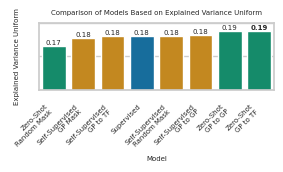

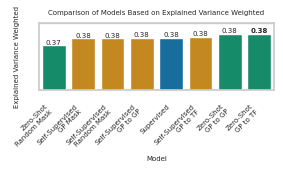

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Map the model types to specific colors
df['Color'] = df['experiment'].map(color_dict)
assert not df['Color'].isnull().any(), "Some model types don't have a color assigned in the color_dict."

# Sort the dataframe for the plots
df_sorted_uniform = df.sort_values('Explained Variance Uniform')
df_sorted_weighted = df.sort_values('Explained Variance Weighted')

# Adjusted function to annotate bars
def annotate_bars(ax, data, score_column):
    max_height = data[score_column].max()
    for p in ax.patches:
        annotation = f"{p.get_height():.2f}"
        weight = 'bold' if p.get_height() == max_height else 'normal'
        ax.annotate(annotation, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=5, weight=weight)

# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 1.75))
ax1 = sns.barplot(x='experiment', y='Explained Variance Uniform', data=df_sorted_uniform,
                  palette=df_sorted_uniform['Color'].tolist())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=5)
ax1.set_yticklabels([])
ax1.set_xlabel('Model', fontsize=5)
ax1.set_ylim((0.1, 0.2))
ax1.set_ylabel('Explained Variance Uniform', fontsize=5)
annotate_bars(ax1, df_sorted_uniform, 'Explained Variance Uniform')
plt.tight_layout()
ax1.set_title('Comparison of Models Based on Explained Variance Uniform', fontsize=5)
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_Model_Comparison_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 1.75))
ax2 = sns.barplot(x='experiment', y='Explained Variance Weighted', data=df_sorted_weighted,
                  palette=df_sorted_weighted['Color'].tolist())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=5)
ax2.set_yticklabels([])
ax2.set_xlabel('Model', fontsize=5)
ax2.set_ylim((0.3, 0.4))
ax2.set_ylabel('Explained Variance Weighted', fontsize=5)
annotate_bars(ax2, df_sorted_weighted, 'Explained Variance Weighted')
plt.tight_layout()
ax2.set_title('Comparison of Models Based on Explained Variance Weighted', fontsize=5)
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_Model_Comparison_EV_Weighted.svg", bbox_inches='tight')
plt.show()


### Figure 2: Model comparison with box-plots

In [13]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report.csv')
pd.set_option('display.max_colwidth', 1000)
df = pd.read_csv(file_path)

df = df.sort_values(by='experiment', ascending=True)

# Filter out unwanted experiments
df = df[df['experiment'].str.contains('NegBin')]

# Split the experiment into 'Model' and 'Run'
df['Model'] = df['experiment'].apply(lambda x: ' '.join(x.split('_')[:-1]))

# Include the experiment labeled 'NaN'
df.loc[df['experiment'].isnull(), 'experiment'] = 'MLP_bt_Gaussian_0_001_run0'

# Now the DataFrame is ready for boxplot visualization
df.head()  # Display the first few rows to verify the data

df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE,Model
37,CN_NegBin_50prun0,0.166044,0.366818,0.102326,CN NegBin
49,CN_NegBin_50prun1,0.166076,0.367275,0.102223,CN NegBin
50,CN_NegBin_50prun2,0.157059,0.366830,0.102297,CN NegBin
51,CN_NegBin_50prun3,0.163737,0.366949,0.102262,CN NegBin
52,CN_NegBin_50prun4,0.164499,0.366672,0.102324,CN NegBin
39,CN_NegBin_gp_to_tfrun0,0.187810,0.383466,0.099487,CN NegBin gp to
40,CN_NegBin_gp_to_tfrun1,0.187587,0.383286,0.099528,CN NegBin gp to
41,CN_NegBin_gp_to_tfrun2,0.185744,0.383344,0.099517,CN NegBin gp to
42,CN_NegBin_gp_to_tfrun3,0.188583,0.383413,0.099498,CN NegBin gp to
43,CN_NegBin_gp_to_tfrun4,0.188651,0.383535,0.099481,CN NegBin gp to


In [14]:
"""
models_to_select = ['CN_MLP_gp_to_tf', 
                    'CN_MLP_gp_to_tfrun1', 
                    'CN_MLP_gp_to_tfrun2', 
                    'CN_MLP_gp_to_tfrun3', 
                    'CN_MLP_gp_to_tfrun4', 
                    'CN_No_SSL_CN_MLPrun0',
                    'CN_No_SSL_CN_MLPrun1',
                    'CN_No_SSL_CN_MLPrun2',
                    'CN_No_SSL_CN_MLPrun3',
                    'CN_No_SSL_CN_MLPrun4', 
                    'CN_SSL_CN_CN_MLP_gp_to_tfrun0',
                    'CN_SSL_CN_CN_MLP_gp_to_tfrun1',
                    'CN_SSL_CN_CN_MLP_gp_to_tfrun2',
                    'CN_SSL_CN_CN_MLP_gp_to_tfrun3',
                    'CN_SSL_CN_CN_MLP_gp_to_tfrun4',
                   ]

df_subset = df[df['experiment'].isin(models_to_select)]
df_subset
"""

models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                   ]

df_subset = df[df['experiment'].isin(models_to_select)]
df_subset

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE,Model
39,CN_NegBin_gp_to_tfrun0,0.187810,0.383466,0.099487,CN NegBin gp to
40,CN_NegBin_gp_to_tfrun1,0.187587,0.383286,0.099528,CN NegBin gp to
41,CN_NegBin_gp_to_tfrun2,0.185744,0.383344,0.099517,CN NegBin gp to
42,CN_NegBin_gp_to_tfrun3,0.188583,0.383413,0.099498,CN NegBin gp to
43,CN_NegBin_gp_to_tfrun4,0.188651,0.383535,0.099481,CN NegBin gp to
32,CN_No_SSL_CN_run0NegBin_,0.178914,0.378889,0.100295,CN No SSL CN run0NegBin
33,CN_No_SSL_CN_run1NegBin_,0.180600,0.378120,0.100453,CN No SSL CN run1NegBin
34,CN_No_SSL_CN_run2NegBin_,0.176232,0.378180,0.100393,CN No SSL CN run2NegBin
35,CN_No_SSL_CN_run3NegBin_,0.176843,0.377674,0.100521,CN No SSL CN run3NegBin
36,CN_No_SSL_CN_run4NegBin_,0.176809,0.377811,0.100471,CN No SSL CN run4NegBin


In [15]:

def extract_model_type(row):
    if 'SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised\nGP to TF'
    elif 'No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot\nGP to TF'
    else:
        return 'Unknown'

# Apply the function to the dataframe
df_subset['Model'] = df_subset.apply(extract_model_type, axis=1)
df_subset

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE,Model
39,CN_NegBin_gp_to_tfrun0,0.187810,0.383466,0.099487,Zero-Shot\nGP to TF
40,CN_NegBin_gp_to_tfrun1,0.187587,0.383286,0.099528,Zero-Shot\nGP to TF
41,CN_NegBin_gp_to_tfrun2,0.185744,0.383344,0.099517,Zero-Shot\nGP to TF
42,CN_NegBin_gp_to_tfrun3,0.188583,0.383413,0.099498,Zero-Shot\nGP to TF
43,CN_NegBin_gp_to_tfrun4,0.188651,0.383535,0.099481,Zero-Shot\nGP to TF
32,CN_No_SSL_CN_run0NegBin_,0.178914,0.378889,0.100295,Supervised
33,CN_No_SSL_CN_run1NegBin_,0.180600,0.378120,0.100453,Supervised
34,CN_No_SSL_CN_run2NegBin_,0.176232,0.378180,0.100393,Supervised
35,CN_No_SSL_CN_run3NegBin_,0.176843,0.377674,0.100521,Supervised
36,CN_No_SSL_CN_run4NegBin_,0.176809,0.377811,0.100471,Supervised


<Figure size 300x200 with 0 Axes>

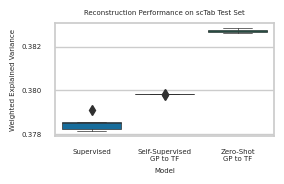

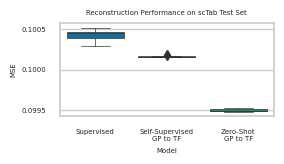

<Figure size 640x480 with 0 Axes>

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

############################
# Suspected bug in seaborn #
############################

# Define the order of models
model_order = ["Supervised", "Self-Supervised\nGP to TF", "Zero-Shot\nGP to TF"]

# Define color mapping for each model type
model_colors = {
    "Supervised": color_supervised,
    "Self-Supervised\nGP to TF": color_ssl,
    "Zero-Shot\nGP to TF": color_zeroshot,
}

# Debugging: Print median values before plotting
# print(df_subset.groupby('Model')['f1-score: macro avg'].median())

# Plot for Macro F1 Score with individual points
plt.figure(figsize=(3, 2))
# Plot for Macro F1 Score with individual points
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Model', y='Explained Variance Weighted', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Weighted Explained Variance', fontdict=font)
ax1.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(3, 1.8))
ax2 = sns.boxplot(x='Model', y='MSE', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('MSE', fontdict=font)
ax2.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


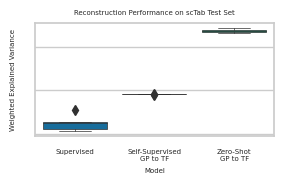

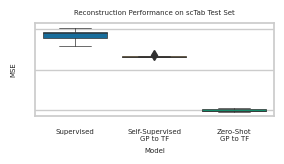

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of models
model_order = ["Supervised", "Self-Supervised\nGP to TF", "Zero-Shot\nGP to TF"]

# Define color mapping for each model type
model_colors = {
    "Supervised": color_supervised,
    "Self-Supervised\nGP to TF": color_ssl,
    "Zero-Shot\nGP to TF": color_zeroshot,
}

# Debugging: Print median values before plotting
# print(df_subset.groupby('Model')['f1-score: macro avg'].median())

# Plot for Macro F1 Score with individual points
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Model', y='Explained Variance Weighted', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels([])
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Weighted Explained Variance', fontdict=font)
ax1.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_Model_Comparison_Weighted_EV_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(3, 1.8))
ax2 = sns.boxplot(x='Model', y='MSE', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels([])
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('MSE', fontdict=font)
ax2.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_Model_Comparison_MSE_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()


# Fig 3: OOD Reconstruction

**Dissection: Tail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC**

- 56,367 cells
- 10x 3' v3
- hippocampal formation
- astrocyte (3761), central nervous system macrophage (1782), endothelial cell (174), ependymal cell (111), ~~fibroblast (86)~~, leukocyte (36), neuron (36588), oligodendrocyte (11875), oligodendrocyte precursor cell (1896), pericyte (39), vascular associated smooth muscle cell (19)

In [18]:
ood_set = 'tail_of_hippocampus'

In [19]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)

df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale
# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
4,CN_MLP_gp_to_tf,0.016797,0.054392,0.135386
7,CN_MLP_gp_to_tfrun1,0.016014,0.054289,0.135240
8,CN_MLP_gp_to_tfrun2,0.016815,0.054107,0.135342
9,CN_MLP_gp_to_tfrun3,0.016650,0.053559,0.135497
10,CN_MLP_gp_to_tfrun4,0.016509,0.053556,0.135474
21,CN_NegBin_gp_to_tfrun0,0.023352,0.077961,0.103577
22,CN_NegBin_gp_to_tfrun1,0.023128,0.077546,0.103651
23,CN_NegBin_gp_to_tfrun2,0.023136,0.077902,0.103598
24,CN_NegBin_gp_to_tfrun3,0.023033,0.077681,0.103649
25,CN_NegBin_gp_to_tfrun4,0.023282,0.077862,0.103494


In [20]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
21,CN_NegBin_gp_to_tfrun0,0.023352,0.077961,0.103577
22,CN_NegBin_gp_to_tfrun1,0.023128,0.077546,0.103651
23,CN_NegBin_gp_to_tfrun2,0.023136,0.077902,0.103598
24,CN_NegBin_gp_to_tfrun3,0.023033,0.077681,0.103649
25,CN_NegBin_gp_to_tfrun4,0.023282,0.077862,0.103494
16,CN_No_SSL_CN_run0NegBin_,0.021411,0.073359,0.104621
17,CN_No_SSL_CN_run1NegBin_,0.021023,0.072452,0.104728
18,CN_No_SSL_CN_run2NegBin_,0.021274,0.072865,0.104778
19,CN_No_SSL_CN_run3NegBin_,0.021309,0.072595,0.104942
20,CN_No_SSL_CN_run4NegBin_,0.021053,0.072447,0.104825


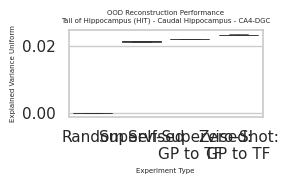

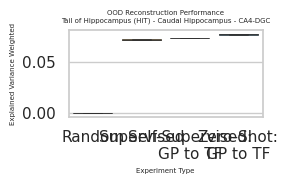

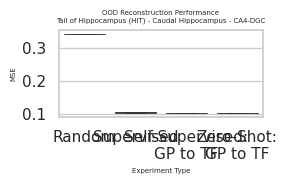

In [21]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors1 = [color_supervised, color_ssl, color_zeroshot]
model_colors2 = [color_ssl, color_supervised, color_zeroshot]

# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors2)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)


plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_HiT_EV_Uniforma.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors1)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_HiT_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors2)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_HiT_MSE.svg", bbox_inches='tight')
plt.show()

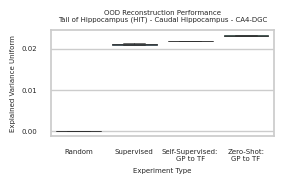

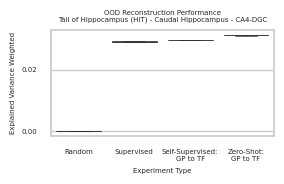

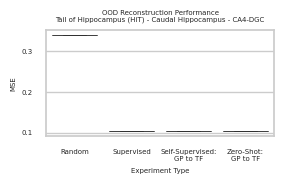

In [22]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors1 = [color_baseline, color_supervised, color_ssl, color_zeroshot]

# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors1)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)


plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_HiT_EV_Uniforma.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors1)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_HiT_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors1)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_HiT_MSE.svg", bbox_inches='tight')
plt.show()

**All non-neuronal cells**

- 888,263 cells
- 10x 3' v3
- Bergmann glial cell (8041), astrocyte (155025), central nervous system macrophage (91383), ~~choroid plexus epithelial cell (7689)~~, endothelial cell (5165), ependymal cell (5882), ~~fibroblast (9156)~~, oligodendrocyte (494966), oligodendrocyte precursor cell (105734), pericyte (3693), vascular associated smooth muscle cell (1074)

In [23]:
ood_set = 'non_neuronal'

In [24]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale

# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
4,CN_MLP_gp_to_tf,0.010968,0.031574,0.167407
7,CN_MLP_gp_to_tfrun1,0.010871,0.031213,0.167461
8,CN_MLP_gp_to_tfrun2,0.010803,0.031138,0.167452
9,CN_MLP_gp_to_tfrun3,0.010688,0.030957,0.167512
10,CN_MLP_gp_to_tfrun4,0.010740,0.031110,0.167491
21,CN_NegBin_gp_to_tfrun0,0.013726,0.042998,0.141012
22,CN_NegBin_gp_to_tfrun1,0.013720,0.043067,0.141046
23,CN_NegBin_gp_to_tfrun2,0.013781,0.043148,0.141037
24,CN_NegBin_gp_to_tfrun3,0.013743,0.043060,0.141027
25,CN_NegBin_gp_to_tfrun4,0.013812,0.043246,0.140969


In [25]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
21,CN_NegBin_gp_to_tfrun0,0.013726,0.042998,0.141012
22,CN_NegBin_gp_to_tfrun1,0.013720,0.043067,0.141046
23,CN_NegBin_gp_to_tfrun2,0.013781,0.043148,0.141037
24,CN_NegBin_gp_to_tfrun3,0.013743,0.043060,0.141027
25,CN_NegBin_gp_to_tfrun4,0.013812,0.043246,0.140969
16,CN_No_SSL_CN_run0NegBin_,0.012459,0.039654,0.141772
17,CN_No_SSL_CN_run1NegBin_,0.012308,0.039245,0.141851
18,CN_No_SSL_CN_run2NegBin_,0.012287,0.039288,0.141851
19,CN_No_SSL_CN_run3NegBin_,0.012142,0.038822,0.142076
20,CN_No_SSL_CN_run4NegBin_,0.012201,0.039008,0.141991


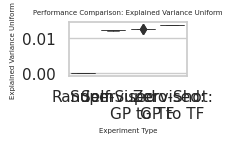

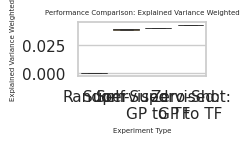

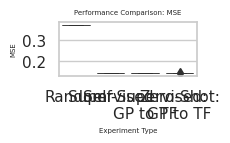

In [26]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Performance Comparison: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_nn_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Performance Comparison: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_nn_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Performance Comparison: MSE', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_nn_MSE.svg", bbox_inches='tight')
plt.show()

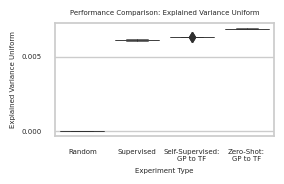

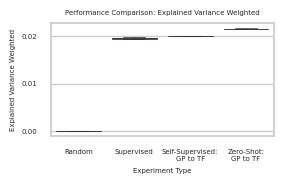

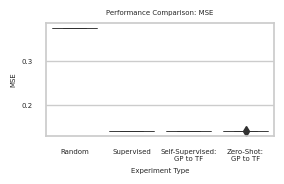

In [27]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_baseline, color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Performance Comparison: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_nn_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Performance Comparison: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_nn_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Performance Comparison: MSE', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_nn_MSE.svg", bbox_inches='tight')
plt.show()

### **Circulating Immune cells -- CV19 infection, vaccination and HC**

- 195,632 cells
- 10x 5' v1 10x 5' v2
- B Cell (21190), CD4-positive, alpha-beta T cell (61350), CD8-positive, alpha-beta T cell (35752), T cell (1407), dendritic cell (3368), gamma-delta T cell (3184), monocyte (38476), mucosal invariant T cell (1244), natural killer cell (28834), stem cell (827) 

In [28]:
ood_set = 'circ_imm'

In [29]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
5,CN_MLP_gp_to_tf,0.026249,0.072848,0.187753
6,CN_MLP_gp_to_tfrun1,0.026016,0.072213,0.187864
7,CN_MLP_gp_to_tfrun2,0.025970,0.072127,0.187864
8,CN_MLP_gp_to_tfrun3,0.026072,0.072238,0.187888
9,CN_MLP_gp_to_tfrun4,0.025942,0.072049,0.187910
21,CN_NegBin_gp_to_tfrun0,0.031065,0.091313,0.164153
22,CN_NegBin_gp_to_tfrun1,0.031067,0.091281,0.163992
23,CN_NegBin_gp_to_tfrun2,0.031038,0.091322,0.164009
24,CN_NegBin_gp_to_tfrun3,0.031073,0.091274,0.164218
25,CN_NegBin_gp_to_tfrun4,0.031163,0.091319,0.164091


In [30]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
21,CN_NegBin_gp_to_tfrun0,0.031065,0.091313,0.164153
22,CN_NegBin_gp_to_tfrun1,0.031067,0.091281,0.163992
23,CN_NegBin_gp_to_tfrun2,0.031038,0.091322,0.164009
24,CN_NegBin_gp_to_tfrun3,0.031073,0.091274,0.164218
25,CN_NegBin_gp_to_tfrun4,0.031163,0.091319,0.164091
16,CN_No_SSL_CN_run0NegBin_,0.029371,0.087914,0.164859
17,CN_No_SSL_CN_run1NegBin_,0.029113,0.087265,0.165101
18,CN_No_SSL_CN_run2NegBin_,0.029094,0.087432,0.165183
19,CN_No_SSL_CN_run3NegBin_,0.029028,0.086988,0.165218
20,CN_No_SSL_CN_run4NegBin_,0.029165,0.087373,0.165027


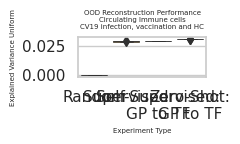

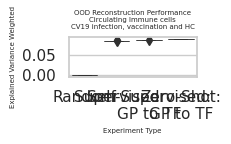

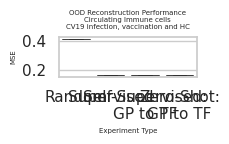

In [31]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_circ_imm_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_circ_imm_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_circ_imm_MSE.svg", bbox_inches='tight')
plt.show()

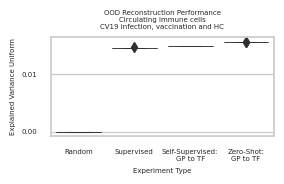

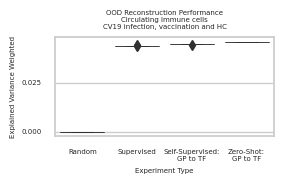

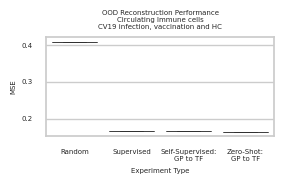

In [32]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_baseline, color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3,2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_circ_imm_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_circ_imm_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_circ_imm_MSE.svg", bbox_inches='tight')
plt.show()

### **Single-cell analysis of prenatal and postnatal human cortical development**

- 709,372 cells
- 110x 3' v2, 10x 3' v3, 10x multiome
- astrocyte (67868), microglial cell (15857), native cell (15828), neural cell (537452), oligodendrocyte (40875), oligodendrocyte precursor cell (31392)

In [33]:
ood_set = 'cort_dev'

In [34]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.

# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale

# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
5,CN_MLP_gp_to_tf,0.017552,0.065724,0.209839
6,CN_MLP_gp_to_tfrun1,0.017088,0.065098,0.210036
7,CN_MLP_gp_to_tfrun2,0.017473,0.064634,0.209988
8,CN_MLP_gp_to_tfrun3,0.016492,0.064929,0.210147
9,CN_MLP_gp_to_tfrun4,0.017229,0.065143,0.209932
21,CN_NegBin_gp_to_tfrun0,0.020516,0.077377,0.202370
22,CN_NegBin_gp_to_tfrun1,0.020761,0.077434,0.202159
23,CN_NegBin_gp_to_tfrun2,0.020024,0.077156,0.202410
24,CN_NegBin_gp_to_tfrun3,0.020326,0.077448,0.202416
25,CN_NegBin_gp_to_tfrun4,0.019827,0.077232,0.202568


In [35]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
21,CN_NegBin_gp_to_tfrun0,0.020516,0.077377,0.202370
22,CN_NegBin_gp_to_tfrun1,0.020761,0.077434,0.202159
23,CN_NegBin_gp_to_tfrun2,0.020024,0.077156,0.202410
24,CN_NegBin_gp_to_tfrun3,0.020326,0.077448,0.202416
25,CN_NegBin_gp_to_tfrun4,0.019827,0.077232,0.202568
16,CN_No_SSL_CN_run0NegBin_,0.017135,0.073678,0.203821
17,CN_No_SSL_CN_run1NegBin_,0.018928,0.073976,0.203417
18,CN_No_SSL_CN_run2NegBin_,0.017994,0.073692,0.203793
19,CN_No_SSL_CN_run3NegBin_,0.017893,0.072983,0.203862
20,CN_No_SSL_CN_run4NegBin_,0.018520,0.073770,0.203333


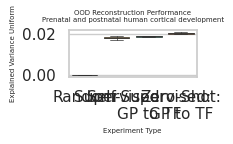

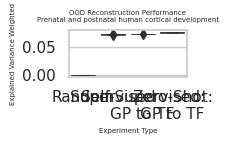

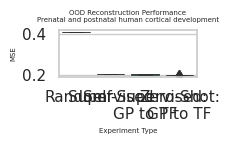

In [36]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_cort_dev_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_cort_dev_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_cort_dev_MSE.svg", bbox_inches='tight')
plt.show()

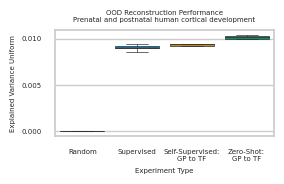

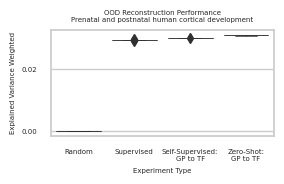

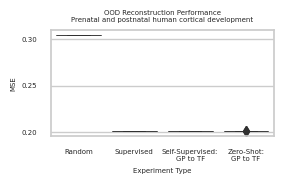

In [37]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_baseline, color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3,2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_cort_dev_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3,2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_cort_dev_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_cort_dev_MSE.svg", bbox_inches='tight')
plt.show()

### **Human: Great apes study**

- 156,285 cells
- 10x 3' v3 Smart-seq v4
- L2/3-6 intratelencephalic projecting glutamatergic cortical neuron (85276), L5 something not included (392), L6b glutamatergic cortical neuron (3415), astrocyte of the cerebral cortex (3047), caudial ganglio... not included (844), cerebral cortex endothelial cell (168), chandelier pval (728), cortocothalami... (3118), lamp5 GABAeric... (6416), microglial cell (1263), near-projecting ... (3461), oligodendrocyte (7876), oligodendrocyte precursor cell (2392), pvalb GABAergic (11778), sncg GABAergic (2025), sst GABAergic cortical interneuron (13593), vascular leptomeningeal cell (276), vip GABAergic cortical interneuron (10219)

In [38]:
ood_set = 'great_apes'

In [39]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale

# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
5,CN_MLP_gp_to_tf,0.024444,0.059756,0.136057
6,CN_MLP_gp_to_tfrun1,0.021353,0.057891,0.135582
7,CN_MLP_gp_to_tfrun2,0.023180,0.059845,0.135237
8,CN_MLP_gp_to_tfrun3,0.022981,0.059238,0.135176
9,CN_MLP_gp_to_tfrun4,0.023337,0.060068,0.134910
21,CN_NegBin_gp_to_tfrun0,0.005581,0.051207,0.146498
22,CN_NegBin_gp_to_tfrun1,-0.037511,0.044358,0.145583
23,CN_NegBin_gp_to_tfrun2,-0.097389,0.015866,0.146910
24,CN_NegBin_gp_to_tfrun3,-24.085745,-0.623719,0.326163
25,CN_NegBin_gp_to_tfrun4,-0.038573,0.041535,0.146178


In [40]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
21,CN_NegBin_gp_to_tfrun0,0.005581,0.051207,0.146498
22,CN_NegBin_gp_to_tfrun1,-0.037511,0.044358,0.145583
23,CN_NegBin_gp_to_tfrun2,-0.097389,0.015866,0.146910
24,CN_NegBin_gp_to_tfrun3,-24.085745,-0.623719,0.326163
25,CN_NegBin_gp_to_tfrun4,-0.038573,0.041535,0.146178
16,CN_No_SSL_CN_run0NegBin_,0.002519,0.047960,0.146269
17,CN_No_SSL_CN_run1NegBin_,0.002919,0.047754,0.147673
18,CN_No_SSL_CN_run2NegBin_,0.004591,0.047177,0.146598
19,CN_No_SSL_CN_run3NegBin_,-8.083727,-0.194000,0.200676
20,CN_No_SSL_CN_run4NegBin_,0.001042,0.046750,0.147277


In [41]:
df = df[~df['experiment'].isin(['CN_NegBin_gp_to_tfrun3', 'CN_NegBin_gp_to_tfrun2', 'CN_No_SSL_CN_run3NegBin_', ])]  # Remove Outliers

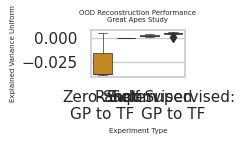

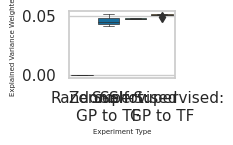

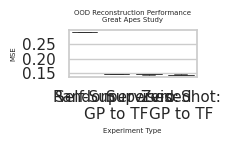

In [42]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_ssl, color_supervised, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_Great_Apes_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
# ax2.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/OOD_Great_Apes_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/OOD_Great_Apes_MSE.svg", bbox_inches='tight')
plt.show()

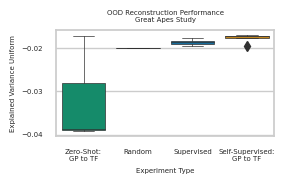

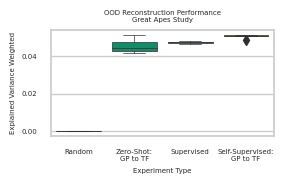

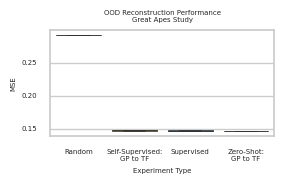

In [43]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors1 = [color_zeroshot, color_baseline, color_supervised, color_ssl]
model_colors2 = [color_baseline, color_zeroshot, color_supervised, color_ssl]
model_colors3 = [color_baseline, color_ssl, color_supervised, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors1)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_Great_Apes_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors2)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_Great_Apes_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors3)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_OOD_Great_Apes_MSE.svg", bbox_inches='tight')
plt.show()

# Fig 4: Individual Atlas

### HLCA

In [44]:
supervised_subset = 148  # HLCA

In [45]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_148.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
# df = df[~df['experiment'].str.contains('NegBin')]

# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
2,CN_MLP_gp_to_tf,0.045098,0.182332,0.131056
3,CN_MLP_gp_to_tfrun1,0.044219,0.181308,0.131141
4,CN_MLP_gp_to_tfrun2,0.044151,0.181282,0.131127
5,CN_MLP_gp_to_tfrun3,0.044105,0.181357,0.131149
6,CN_MLP_gp_to_tfrun4,0.043465,0.181216,0.131137
28,CN_NegBin_gp_to_tfrun0,0.048608,0.271839,0.094054
29,CN_NegBin_gp_to_tfrun1,0.047480,0.271660,0.094078
30,CN_NegBin_gp_to_tfrun2,0.047602,0.271747,0.094065
31,CN_NegBin_gp_to_tfrun3,0.047968,0.271646,0.094073
32,CN_NegBin_gp_to_tfrun4,0.049100,0.271641,0.094071


In [46]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_new_run0NegBin__HLCA',
                    'CN_No_SSL_CN_new_run1NegBin__HLCA',
                    'CN_No_SSL_CN_new_run2NegBin__HLCA',
                    'CN_No_SSL_CN_new_run3NegBin__HLCA',
                    'CN_No_SSL_CN_new_run4NegBin__HLCA', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__HLCA',
                    # 'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
28,CN_NegBin_gp_to_tfrun0,0.048608,0.271839,0.094054
29,CN_NegBin_gp_to_tfrun1,0.047480,0.271660,0.094078
30,CN_NegBin_gp_to_tfrun2,0.047602,0.271747,0.094065
31,CN_NegBin_gp_to_tfrun3,0.047968,0.271646,0.094073
32,CN_NegBin_gp_to_tfrun4,0.049100,0.271641,0.094071
17,CN_No_SSL_CN_new_run0NegBin__HLCA,0.036961,0.264383,0.095144
18,CN_No_SSL_CN_new_run1NegBin__HLCA,0.043978,0.268769,0.094476
19,CN_No_SSL_CN_new_run2NegBin__HLCA,0.039708,0.267578,0.094646
20,CN_No_SSL_CN_new_run3NegBin__HLCA,0.042057,0.267642,0.094616
21,CN_No_SSL_CN_new_run4NegBin__HLCA,0.043333,0.269099,0.094424


In [47]:
np.mean((0.273782, 0.272924, 0.273099, 0.273202, 0.273836))

0.2733686

In [48]:
# Remove the old models
# outliers = ['CN_No_SSL_CN_MLPrun0_HLCA', 'CN_SSL_CN_CN_MLP_gp_to_tfrun0_HLCA']
# df = df[~df['experiment'].isin(outliers)]

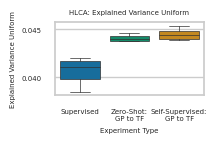

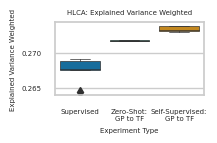

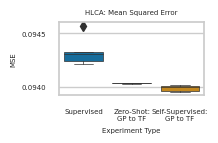

In [49]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
# ordered_types_mse = mean_mse.index.tolist()

# somehow this didn't work
ordered_types_mse = [
    'Supervised' ,
    'Zero-Shot:\nGP to TF',     
    'Self-Supervised:\nGP to TF',  
]

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_zeroshot, color_ssl]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('HLCA: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_HLCA_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('HLCA: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_HLCA_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('HLCA: Mean Squared Error', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_HLCA_MSE.svg", bbox_inches='tight')
plt.show()

### PBMC

In [50]:
supervised_subset = 41  # PBMC

In [73]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_41.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)

# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
2,CN_MLP_gp_to_tf,0.020710,0.089073,0.151431
3,CN_MLP_gp_to_tfrun1,0.020646,0.088599,0.151463
4,CN_MLP_gp_to_tfrun2,0.020673,0.088552,0.151450
5,CN_MLP_gp_to_tfrun3,0.020637,0.088483,0.151486
6,CN_MLP_gp_to_tfrun4,0.020687,0.088612,0.151471
27,CN_NegBin_gp_to_tfrun0,0.025738,0.139632,0.112569
28,CN_NegBin_gp_to_tfrun1,0.025799,0.139740,0.112571
29,CN_NegBin_gp_to_tfrun2,0.025789,0.139750,0.112569
30,CN_NegBin_gp_to_tfrun3,0.025768,0.139874,0.112548
31,CN_NegBin_gp_to_tfrun4,0.025807,0.139762,0.112558


In [74]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_new_run2NegBin__PBMC',
                    'CN_No_SSL_CN_new_run5NegBin__PBMC',
                    'CN_No_SSL_CN_new_run1NegBin__PBMC',
                    'CN_No_SSL_CN_new_run6NegBin__PBMC',
                    'CN_No_SSL_CN_new_run4NegBin__PBMC', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__PBMC',
                    # 'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run6NegBin__PBMC',
                    # 'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
27,CN_NegBin_gp_to_tfrun0,0.025738,0.139632,0.112569
28,CN_NegBin_gp_to_tfrun1,0.025799,0.139740,0.112571
29,CN_NegBin_gp_to_tfrun2,0.025789,0.139750,0.112569
30,CN_NegBin_gp_to_tfrun3,0.025768,0.139874,0.112548
31,CN_NegBin_gp_to_tfrun4,0.025807,0.139762,0.112558
8,CN_No_SSL_CN_new_run1NegBin__PBMC,0.024767,0.138389,0.112702
9,CN_No_SSL_CN_new_run2NegBin__PBMC,0.024969,0.138063,0.112725
26,CN_No_SSL_CN_new_run4NegBin__PBMC,0.024975,0.138858,0.112638
38,CN_No_SSL_CN_new_run5NegBin__PBMC,0.024894,0.138295,0.112721
39,CN_No_SSL_CN_new_run6NegBin__PBMC,0.024959,0.138638,0.112688


In [59]:
np.mean((0.138712, 0.138744	, 0.138502, 0.139419, 0.138981))

0.1388716

In [30]:
# Remove the old models
# outliers = ['CN_No_SSL_CN_MLPrun0_PBMC', 'CN_SSL_CN_CN_MLP_gp_to_tfrun0_PBMC']
# df = df[~df['experiment'].isin(outliers)]

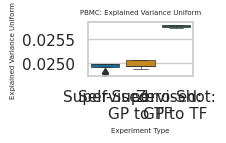

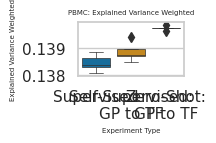

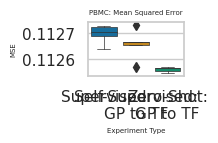

In [75]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# somehow this didn't work
ordered_types_mse = [
    'Supervised' ,
    'Self-Supervised:\nGP to TF',  
    'Zero-Shot:\nGP to TF',     
    
]

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('PBMC: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/NegBin_PBMC_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('PBMC: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/NegBin_PBMC_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('PBMC: Mean Squared Error', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/NegBin_PBMC_MSE.svg", bbox_inches='tight')
plt.show()

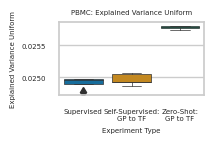

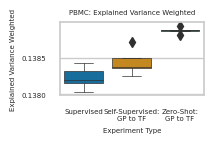

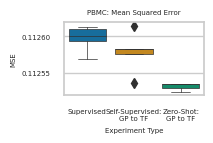

In [60]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# somehow this didn't work
ordered_types_mse = [
    'Supervised' ,
    'Self-Supervised:\nGP to TF',  
    'Zero-Shot:\nGP to TF',     
    
]

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('PBMC: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_PBMC_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('PBMC: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_PBMC_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('PBMC: Mean Squared Error', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_PBMC_MSE.svg", bbox_inches='tight')
plt.show()

### Tabula Sapiens

In [66]:
supervised_subset = 87  # Tabula Sapiens

In [67]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_87.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
# df = df[~df['experiment'].str.contains('NegBin')]


# Show the first few rows to get an overview of the data
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
2,CN_MLP_gp_to_tf,6.148518e-02,1.981706e-01,1.234487e-01
3,CN_MLP_gp_to_tfrun1,6.075163e-02,1.975736e-01,1.235797e-01
4,CN_MLP_gp_to_tfrun2,6.127269e-02,1.970689e-01,1.235991e-01
5,CN_MLP_gp_to_tfrun3,6.102591e-02,1.973164e-01,1.235910e-01
6,CN_MLP_gp_to_tfrun4,5.974605e-02,1.970365e-01,1.236104e-01
18,CN_NegBin_gp_to_tfrun0,6.875557e-02,2.971505e-01,8.185578e-02
19,CN_NegBin_gp_to_tfrun1,6.232605e-02,2.964328e-01,8.193294e-02
20,CN_NegBin_gp_to_tfrun2,6.488585e-02,2.970955e-01,8.188640e-02
21,CN_NegBin_gp_to_tfrun3,6.509556e-02,2.973587e-01,8.174691e-02
22,CN_NegBin_gp_to_tfrun4,6.602353e-02,2.972398e-01,8.165064e-02


In [68]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_new_run5NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run6NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run7NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run8NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run9NegBin__Tabula_Sapiens',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__Tabula_Sapiens',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__Tabula_Sapiens',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__Tabula_Sapiens',
                    # 'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__Tabula_Sapiens',  # Outlier
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__Tabula_Sapiens',
                    # 'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

,experiment,Explained Variance Uniform,Explained Variance Weighted,MSE
18,CN_NegBin_gp_to_tfrun0,0.068756,0.297151,0.081856
19,CN_NegBin_gp_to_tfrun1,0.062326,0.296433,0.081933
20,CN_NegBin_gp_to_tfrun2,0.064886,0.297096,0.081886
21,CN_NegBin_gp_to_tfrun3,0.065096,0.297359,0.081747
22,CN_NegBin_gp_to_tfrun4,0.066024,0.297240,0.081651
36,CN_No_SSL_CN_new_run5NegBin__Tabula_Sapiens,0.036998,0.249776,0.087112
34,CN_No_SSL_CN_new_run6NegBin__Tabula_Sapiens,0.026674,0.247666,0.087408
35,CN_No_SSL_CN_new_run7NegBin__Tabula_Sapiens,0.037480,0.247925,0.087350
37,CN_No_SSL_CN_new_run8NegBin__Tabula_Sapiens,0.031704,0.246705,0.087502
38,CN_No_SSL_CN_new_run9NegBin__Tabula_Sapiens,0.031885,0.246449,0.087564


In [69]:
np.mean((0.249776, 0.247666, 0.247925, 0.246705, 0.246449))

0.24770419999999999

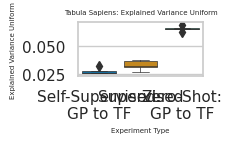

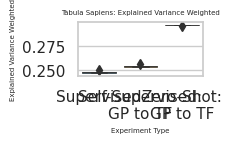

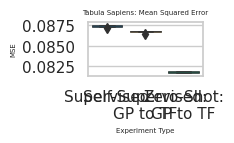

In [70]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = ['Supervised', 'Self-Supervised:\nGP to TF', 'Zero-Shot:\nGP to TF']
 # mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Tabula Sapiens: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/Tabula_Sapiens_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Tabula Sapiens: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/Tabula_Sapiens_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Tabula Sapiens: Mean Squared Error', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/Tabula_Sapiens_MSE.svg", bbox_inches='tight')
plt.show()

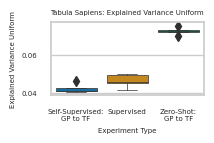

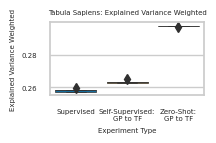

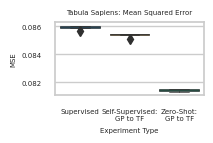

In [71]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = ['Supervised', 'Self-Supervised:\nGP to TF', 'Zero-Shot:\nGP to TF']
 # mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Tabula Sapiens: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_Tabula_Sapiens_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Tabula Sapiens: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_Tabula_Sapiens_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Tabula Sapiens: Mean Squared Error', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/NegBin_Tabula_Sapiens_MSE.svg", bbox_inches='tight')
plt.show()

# Fig 5: Cell type specificities?

In [65]:
adata = anndata.AnnData(
    X=np.load(os.path.join(DATA_PATH, 'pca/x_pca_test_50.npy')), 
)
adata

AnnData object with n_obs × n_vars = 3448832 × 50

In [66]:
y_true_raw = dd.read_parquet(os.path.join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
y_true = y_true_raw
y_true

array([140, 129,  14, ...,  19, 129, 160])

In [67]:
cell_type_mapping = pd.read_parquet(os.path.join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
adata.obs['y_true'] = cell_type_mapping.loc[y_true].to_numpy().flatten()

In [68]:
ckpt_no_ssl = MODEL_PATH + '/final_models/reconstruction/CN_No_SSL_CN_MLPrun0/default/version_3/checkpoints/best_checkpoint_val.ckpt'
ckpt_ssl = MODEL_PATH + '/final_models/reconstruction/CN_SSL_CN_CN_MLP_gp_to_tfrun0/default/version_1/checkpoints/best_checkpoint_val.ckpt'

In [69]:
# init estim class
estim = EstimatorAutoEncoder(DATA_PATH, hvg=HVG)

# init datamodule
estim.init_datamodule(batch_size=4096) 

# init model
hidden_units = [512, 512, 256, 256, 64]
estim.init_model(
    model_type='mlp_ae',
    model_kwargs={
        'learning_rate': 1e-3,
        'weight_decay': 0.1,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'lr_scheduler_kwargs': {
            'step_size': 2,
            'gamma': 0.9,
            'verbose': True
        },
        'units_encoder': hidden_units,
        'units_decoder': hidden_units[::-1][1:],
    },
)

In [70]:
%autoreload 2
from self_supervision.tester.reconstruction.annotate_adata import annotate_best_model_rec

In [71]:
adata = annotate_best_model_rec(adata=adata, estim=estim, ckpt_no_ssl=ckpt_no_ssl, ckpt_ssl=ckpt_ssl)

In [72]:
adata

AnnData object with n_obs × n_vars = 3448832 × 50
    obs: 'y_true', 'better_model'

In [73]:
# Process adata
cell_freq = adata.obs['y_true'].value_counts()
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_filtered = adata[adata.obs['y_true'].isin(cells_to_plot)]

In [74]:
sc.pp.subsample(adata, n_obs=500_000)
# sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)

In [75]:
sns.set_style("white")

In [76]:
adata.X.shape

(500000, 50)

In [77]:
y_true.shape

(3448832,)

In [78]:
cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 3500].index.tolist()

In [79]:
# Prepare the data subset
adata_plot = adata.copy()
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))
nan_indices = adata_plot.obs['y_true'].isna()
adata_plot = adata_plot[~nan_indices]

# Prepare the data subset
adata_plot = adata.copy()
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))
nan_indices = adata_plot.obs['y_true'].isna()
adata_plot = adata_plot[~nan_indices]

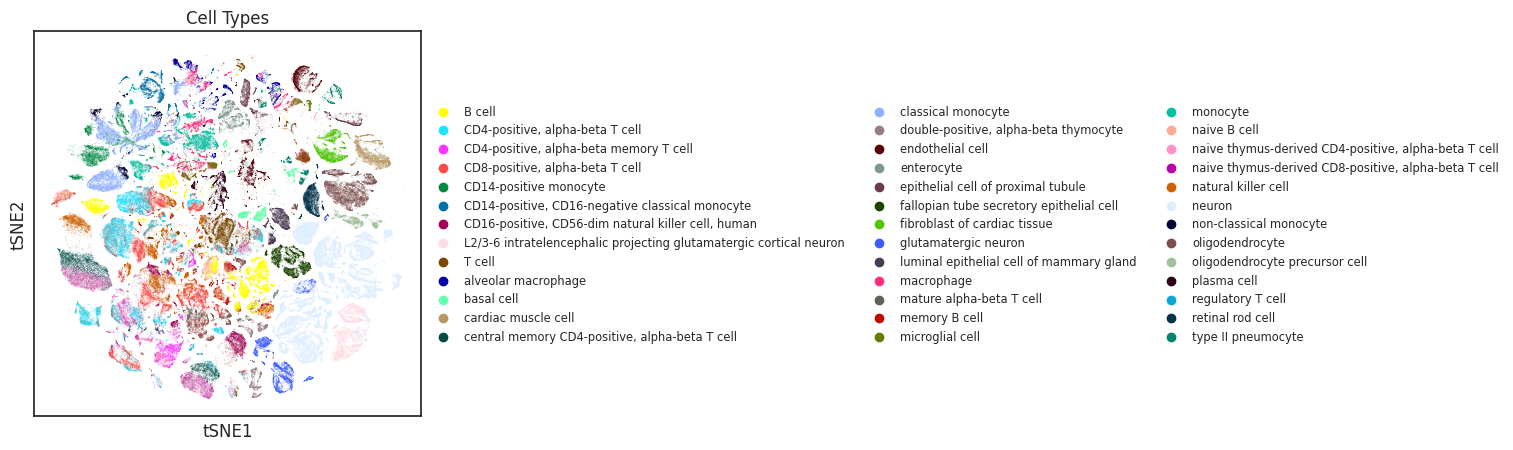

In [80]:
# Prepare for Visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams['figure.figsize'] = (5, 5)
# Create a subplot for the first plot and save it
ax1 = plt.subplot(111)
sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', title='Cell Types', ax=ax1, legend_loc='right margin', save="y_true.pdf")
plt.show()


In [81]:
!mv figures/tsney_true.pdf /lustre/groups/ml01/workspace/till.richter/ssl_results/reconstruction/tsne_ytrue.pdf


In [82]:

# Create a binary comparison plot
plt.rcParams['figure.figsize'] = (5, 5)
# Create a subplot for the first plot and save it
ax1 = plt.subplot(111)
sc.pl.tsne(adata_plot, color='better_model', ax=ax1, show=False, title='Better Model', save="better_model.pdf")
plt.show()



In [83]:
# Ensure divergence calculations and indices are for the same subset of data
divergence_no_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_no_ssl'])**2, axis=1)
divergence_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_ssl'])**2, axis=1)

# Use adata_subsampled.obs.index as the index for both divergence Series
div_series_no_ssl = pd.Series(divergence_no_ssl, index=adata_plot.obs.index)
div_series_ssl = pd.Series(divergence_ssl, index=adata_plot.obs.index)

# Add the divergence series to adata.obs
adata_plot.obs['divergence_no_ssl'] = div_series_no_ssl
adata_plot.obs['divergence_ssl'] = div_series_ssl

plt.rcParams['figure.figsize'] = (10, 10)
# Create a subplot for the first plot
ax1 = plt.subplot(111)
# Create a binary comparison plot
adata_plot.obs['better_model'] = np.where(adata_plot.obs['divergence_no_ssl'] < adata_plot.obs['divergence_ssl'], 'No_SSL', 'SSL')
sc.pl.tsne(adata_plot, color='better_model', ax=ax1, show=False, title='Better Model')
plt.show()



KeyError: 'X_reconst_no_ssl'

# OLD FIGURES

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame

# Remove rows where 'experiment' is NaN
df = df.dropna(subset=['experiment'])

# Extract 'Model' and 'Run' from the 'experiment' column
df['Model'] = df['experiment'].str.rsplit('_', n=1).str[0]
df['Run'] = df['experiment'].str.split('_').str[-1]

# Check if 'Run' is numerical to ensure we can detect single runs
df['Run'] = pd.to_numeric(df['Run'], errors='coerce')

# Group by 'Model' and calculate mean for each metric
grouped_df_mean = df.groupby('Model').mean()

# Group by 'Model' and calculate std for each metric, replacing NaN with 0 for models with single runs
grouped_df_std = df.groupby('Model').std().fillna(0)

# Concatenating mean and std values to create the final table
final_table = pd.concat([grouped_df_mean.add_suffix('_mean'), grouped_df_std.add_suffix('_std')], axis=1)

# Resetting the index to get 'Model' as a column
final_table = final_table.reset_index()

final_table

In [ ]:
# Importing necessary libraries for numerical operations
# import numpy as np
# df = df.drop(0)
# Extracting the model names and stochastic run identifiers from the 'Unnamed: 0' column
# df['Model'] = df['experiment'].apply(lambda x: '_'.join(x.split('_')[:-1]))
# df['Run'] = df['experiment'].apply(lambda x: x.split('_')[-1])

# Grouping by the model names and calculating the mean and standard deviation for each metric
# grouped_df_mean = df.groupby('Model').mean()
# grouped_df_std = df.groupby('Model').std()

# Concatenating mean and std values to create the final table
# final_table = pd.concat([grouped_df_mean.add_suffix('_mean'), grouped_df_std.add_suffix('_std')], axis=1)

# final_table.reset_index()

In [ ]:
# Renaming columns to remove special characters which may cause issues during plotting
final_table.columns = final_table.columns.str.replace(':', '_').str.replace('-', '_').str.replace(' ', '_')

# Updated list of metrics to visualize; considering precision, recall, and ev-score for micro, macro, and weighted averages
updated_metrics_to_visualize = ['Explained_Variance_Uniform', 'Explained_Variance_Weighted', 'MSE']

final_table_reset = final_table.reset_index()

# Updating the list of metrics to visualize based on the available columns
available_metrics_to_visualize = ['Explained_Variance_Uniform', 'Explained_Variance_Weighted', 'MSE']

In [ ]:
# Importing additional libraries for advanced data visualization
# import seaborn as sns

# Focusing on ev-Score metrics
ev_metrics = ['Explained_Variance_Uniform', 'Explained_Variance_Weighted']

# Filter to include only the models of interest for comparison
# models_of_interest = [model for model in final_table_reset['Model'] if "No_SSL_" in model or "SSL_" in model]

# Filtering the DataFrame for these models
# filtered_df = final_table_reset[final_table_reset['Model'].isin(models_of_interest)]


In [ ]:
final_table_reset

In [ ]:
# Renaming the models for better readability
rename_dict = {
    'CN_No_SSL_CN': 'Supervised',
    'CN_MLP': 'Pretrained\nRandom Mask',
    'CN_MLP_gene_program_C8': 'Pretrained\nGene Program Mask',
    'CN_MLP_gp_to': 'Pretrained\nGP to TF',
    'CN_MLP_single_gene': 'Pretrained\nGP to GP',
    'MLP_BYOL_Gaussian_0_001': 'Pretrained\nBYOL',
    'CN_SSL_CN_CN_MLP': 'Self-Supervised\nRandom Mask',
    'CN_SSL_CN_CN_MLP_gp_to': 'Self-Supervised\nGP to TF',
    'CN_SSL_CN_CN_MLP_single_gene': 'Self-Supervised\nGP to GP',
    'CN_SSL_CN_MLP_BYOL_Gaussian_0': 'Self-Supervised\nBYOL',
    'CN_SSL_CN_contrastive_MLP_bt_Gaussian_0': 'Self-Supervised\nBarlow Twins',
    # ...
}

df['Model'] = df['Model'].replace(rename_dict)

# Setting a color-blind friendly palette
palette = sns.color_palette("colorblind")

In [ ]:
df

In [ ]:
filtered_df = filtered_df.loc[[0, 1, 3, 4, 2, 5]]
filtered_df

## Barplots

In [ ]:
# Create a single subplot for the first metric in ev_metrics
fig, ax = plt.subplots(figsize=(12, 8))
# fig.suptitle(f'In-depth Analysis of {ev_metrics[0]}')

# Using seaborn for advanced visualization
sns.barplot(x='Model', y=f'{ev_metrics[0]}_mean', data=filtered_df, ax=ax, palette=palette, capsize=.2)

# Adding error bars for standard deviation
ax.errorbar(x=np.arange(len(models_of_interest)), y=filtered_df[f'{ev_metrics[0]}_mean'], 
            yerr=filtered_df[f'{ev_metrics[0]}_std'], fmt='o', color='black', label='Std Dev')

# Additional plot settings
ax.set_title(f'Mean and Std Dev of {ev_metrics[0].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
ax.legend(title='Model')
ax.set_ylim(0.15, 0.2)
fig.savefig(RESULT_PATH + "/reconstruction/barplot_micro_ev_all_models.pdf")


In [ ]:
# Create a single subplot for the second metric in ev_metrics
fig, ax = plt.subplots(figsize=(12, 8))
# fig.suptitle(f'In-depth Analysis of {ev_metrics[1]}')

# Using seaborn for advanced visualization
sns.barplot(x='Model', y=f'{ev_metrics[1]}_mean', data=filtered_df, ax=ax, palette=palette, capsize=.2)

# Adding error bars for standard deviation
ax.errorbar(x=np.arange(len(models_of_interest)), y=filtered_df[f'{ev_metrics[1]}_mean'], 
            yerr=filtered_df[f'{ev_metrics[1]}_std'], fmt='o', color='black', label='Std Dev')

# Additional plot settings
ax.set_title(f'Barplot: Mean and Std Dev of {ev_metrics[1].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
ax.legend(title='Model')
ax.set_ylim(0.2, 0.25)
fig.savefig(RESULT_PATH + "/reconstruction/barplot_macro_ev_all_models.pdf")


In [ ]:
comp_df = filtered_df[filtered_df['Model'].isin(['No SSL', 'SSL GP to TF'])]
comp_models_of_interest = models_of_interest[:2]

In [ ]:
# Create a single subplot for the first metric in ev_metrics
fig, ax = plt.subplots(figsize=(9, 8))
# fig.suptitle(f'In-depth Analysis of {ev_metrics[0]}')

# Using seaborn for advanced visualization
sns.barplot(x='Model', y=f'{ev_metrics[0]}_mean', data=comp_df, ax=ax, palette=palette, capsize=.2)

# Adding error bars for standard deviation
ax.errorbar(x=np.arange(len(comp_models_of_interest)), y=comp_df[f'{ev_metrics[0]}_mean'], 
            yerr=comp_df[f'{ev_metrics[0]}_std'], fmt='o', color='black', label='Std Dev')

# Additional plot settings
ax.set_title(f'Mean and Std Dev of {ev_metrics[0].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
ax.legend(title='Model')
ax.set_ylim(0.15, 0.2)
fig.savefig(RESULT_PATH + "/reconstruction/barplot_micro_ev_comp.pdf")


In [ ]:
# Create a single subplot for the second metric in ev_metrics
fig, ax = plt.subplots(figsize=(9, 8))
# fig.suptitle(f'In-depth Analysis of {ev_metrics[1]}')

# Using seaborn for advanced visualization
sns.barplot(x='Model', y=f'{ev_metrics[1]}_mean', data=comp_df, ax=ax, palette=palette, capsize=.2)

# Adding error bars for standard deviation
ax.errorbar(x=np.arange(len(comp_models_of_interest)), y=comp_df[f'{ev_metrics[1]}_mean'], 
            yerr=comp_df[f'{ev_metrics[1]}_std'], fmt='o', color='black', label='Std Dev')

# Additional plot settings
ax.set_title(f'Barplot: Mean and Std Dev of {ev_metrics[1].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
ax.legend(title='Model')
ax.set_ylim(0.2, 0.25)
fig.savefig(RESULT_PATH + "/reconstruction/barplot_macro_ev_comp.pdf")


In [ ]:
filtered_df

In [ ]:
filtered_df

In [ ]:
boxplot_metrics = ['Explained Variance Uniform', 'Explained Variance Weighted']

# Create subplots for barplot and boxplot
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
fig.suptitle('In-depth Analysis of ev-Score Metrics')

# Bar plots
for idx, metric in enumerate(ev_metrics):
    ax = axes[0, idx]
    
    # Using seaborn for advanced visualization
    sns.barplot(x='Model', y=f'{metric}_mean', data=filtered_df, ax=ax, palette=palette, capsize=.2)
    
    # Adding error bars for standard deviation
    ax.errorbar(x=np.arange(len(models_of_interest)), y=filtered_df[f'{metric}_mean'], 
                yerr=filtered_df[f'{metric}_std'], fmt='o', color='black', label='Std Dev')
    
    # Additional plot settings
    ax.set_title(f'Barplot: Mean and Std Dev of {metric.replace("__", ": ").replace("_", " ").title()}')
    ax.set_ylabel('Metric Value')
    ax.legend(title='Model')

# Box plots
for idx, metric in enumerate(boxplot_metrics):
    ax = axes[1, idx]
    
    # Preparing data for boxplot
    box_data = df[df['Model'].isin(list(rename_dict.keys()))][[f'{metric}', 'Model']]
    
    # Define the custom index order
    index_order = [1, 29, 3, 2, 4, 5, 21, 16, 17, 22, 18, 23, 19, 24, 20, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 26, 27, 28]

    # Reorder based on the given index
    box_data = box_data.loc[index_order].reset_index(drop=True)

    
    box_data['Model'] = box_data['Model'].replace(rename_dict)
    
    # Using seaborn for advanced visualization
    sns.boxplot(x='Model', y=f'{metric}', data=box_data, ax=ax, palette=palette)
    
    # Additional plot settings
    ax.set_title(f'Boxplot: Distribution of {metric.replace("__", ": ").replace("_", " ").title()}')
    ax.set_ylabel('Metric Value')

In [ ]:
box_data

## Boxplots

In [ ]:
# Create a single subplot for the first metric in boxplot_metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Preparing data for boxplot
box_data = df[df['Model'].isin(list(rename_dict.keys()))][[f'{boxplot_metrics[0]}', 'Model']]
box_data['Model'] = box_data['Model'].replace(rename_dict)
# Define the custom index order
# index_order = [0, 2, 3, 4, 27, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 1, 25, 26, 28]
index_order = [1, 29, 3, 2, 4, 5, 21, 16, 17, 22, 18, 23, 19, 24, 20, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 26, 27, 28]

# Reorder based on the given index
box_data = box_data.loc[index_order].reset_index(drop=True)

# Using seaborn for advanced visualization
sns.boxplot(x='Model', y=f'{boxplot_metrics[0]}', data=box_data, ax=ax, palette=palette)

# Additional plot settings
ax.set_title(f'Boxplot: Distribution of {boxplot_metrics[0].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
fig.savefig(RESULT_PATH + "/reconstruction/boxplot_micro_ev_all_models.pdf")


In [ ]:
# Create a single subplot for the second metric in boxplot_metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Preparing data for boxplot
box_data = df[df['Model'].isin(list(rename_dict.keys()))][[f'{boxplot_metrics[1]}', 'Model']]
box_data['Model'] = box_data['Model'].replace(rename_dict)
# Define the custom index order
index_order = [1, 29, 3, 2, 4, 5, 21, 16, 17, 22, 18, 23, 19, 24, 20, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 26, 27, 28]

# Reorder based on the given index
box_data = box_data.loc[index_order].reset_index(drop=True)
# Using seaborn for advanced visualization
sns.boxplot(x='Model', y=f'{boxplot_metrics[1]}', data=box_data, ax=ax, palette=palette)

# Additional plot settings
ax.set_title(f'Boxplot: Distribution of {boxplot_metrics[1].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
fig.savefig(RESULT_PATH + "/reconstruction/boxplot_macro_ev_all_models.pdf")



In [ ]:
# Create a single subplot for the first metric in boxplot_metrics
fig, ax = plt.subplots(figsize=(9, 8))

# Preparing data for boxplot
box_data = df[df['Model'].isin(list(rename_dict.keys()))][[f'{boxplot_metrics[0]}', 'Model']]
box_data['Model'] = box_data['Model'].replace(rename_dict)
box_data = box_data[box_data['Model'].isin(['No SSL', 'SSL GP to TF'])]

# Using seaborn for advanced visualization
sns.boxplot(x='Model', y=f'{boxplot_metrics[0]}', data=box_data, ax=ax, palette=palette)

# Additional plot settings
ax.set_title(f'Boxplot: Distribution of {boxplot_metrics[0].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
fig.savefig(RESULT_PATH + "/reconstruction/boxplot_micro_ev_comp.pdf")


In [ ]:
# Create a single subplot for the second metric in boxplot_metrics
fig, ax = plt.subplots(figsize=(9, 8))

# Preparing data for boxplot
box_data = df[df['Model'].isin(list(rename_dict.keys()))][[f'{boxplot_metrics[1]}', 'Model']]
box_data['Model'] = box_data['Model'].replace(rename_dict)
box_data = box_data[box_data['Model'].isin(['No SSL', 'SSL GP to TF'])]

# Using seaborn for advanced visualization
sns.boxplot(x='Model', y=f'{boxplot_metrics[1]}', data=box_data, ax=ax, palette=palette)

# Additional plot settings
ax.set_title(f'Boxplot: Distribution of {boxplot_metrics[1].replace("__", ": ").replace("_", " ").title()}')
ax.set_ylabel('Metric Value')
fig.savefig(RESULT_PATH + "/reconstruction/boxplot_macro_ev_comp.pdf")


## T-Test

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

# Initialize a dictionary to store p-values
p_values = {}

# List of metrics to evaluate
metrics = ['Explained Variance Uniform', 'Explained Variance Weighted']

# Identify models of interest and the baseline model
models_of_interest = df['Model'].unique()
baseline_model = 'CN_HVG_No_SSL_CN'

# Loop through metrics
for metric in metrics:
    # Subset the data for the baseline model
    baseline_data = df[df['Model'] == baseline_model][metric]
    
    # Loop through other models
    for model in models_of_interest:
        if model == baseline_model:
            continue
        # Subset the data for the current SSL model
        ssl_data = df[df['Model'] == model][metric]
        
        # Perform t-test
        t_stat, p_val = ttest_ind(baseline_data, ssl_data, equal_var=False) # Assuming unequal variances
        
        # Store p-values
        p_values[(metric, model)] = p_val

# Convert to DataFrame for readability
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Metric_Model', 'p-value']).sort_values(by='p-value')    
pd.set_option('display.max_colwidth', -1)

p_values_df


In [ ]:
# Initialize a dictionary to store corrected p-values
p_values_corrected = {}

# List of metrics to evaluate (as per your previous example)
metrics = ['Explained Variance Uniform', 'Explained Variance Weighted']

# Identify models of interest and the baseline model
models_of_interest = df['Model'].unique()
baseline_model = 'CN_HVG_No_SSL_CN'

# Loop through the metrics to perform t-tests
for metric in metrics:
    # Data for baseline model
    baseline_data = df[df['Model'] == baseline_model][metric]
    
    # Loop through the models containing SSL in their names
    for model in [m for m in models_of_interest if "SSL" in m]:
        # Data for current model
        model_data = df[df['Model'] == model][metric]
        
        # Perform independent t-test
        t_stat, p_val = ttest_ind(baseline_data, model_data, equal_var=False, nan_policy='omit')
        
        # Store the p-value
        p_values_corrected[(metric, model)] = p_val

# Convert the p-values dictionary to a DataFrame for better readability
p_values_df_corrected = pd.DataFrame(list(p_values_corrected.items()), columns=['Metric_Model', 'p-value']).sort_values(by='p-value')
p_values_df_corrected['Metric'] = p_values_df_corrected['Metric_Model'].apply(lambda x: x[0])
p_values_df_corrected['Model'] = p_values_df_corrected['Metric_Model'].apply(lambda x: x[1])
p_values_df_corrected.drop('Metric_Model', axis=1, inplace=True)
p_values_df_corrected

In [ ]:
df.groupby('Model')[metrics].describe()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from sklearn.utils import resample

# Initialize a dictionary to store Wilcoxon p-values
wilcoxon_p_values = {}

# Initialize a dictionary to store Bootstrap p-values
bootstrap_p_values = {}

# Define metrics
boxplot_metrics = ['Explained Variance Uniform', 'Explained Variance Weighted', 'MSE']

# Loop through the metrics
for metric in boxplot_metrics:
    # Data for the baseline model (assuming it's 'CN_HVG_No_SSL_CN')
    baseline_data = df[df['Model'].str.contains('CN_HVG_No_SSL_CN')][metric].values
    
    # Loop through the SSL models
    for model in df['Model'].unique():
        if 'CN_HVG_No_SSL_CN' in model:
            continue  # Skip the baseline model
        
        # Data for the current model
        model_data = df[df['Model'] == model][metric].values
        
        # Make sure the lengths are the same
        min_len = min(len(baseline_data), len(model_data))
        baseline_data = baseline_data[:min_len]
        model_data = model_data[:min_len]
        
        # Perform Wilcoxon Signed-Rank test
        wilcoxon_stat, wilcoxon_p_val = wilcoxon(baseline_data, model_data, alternative='two-sided', correction=True)
        
        # Store the Wilcoxon p-value
        wilcoxon_p_values[(metric, model)] = wilcoxon_p_val
        
        # Bootstrap resampling to get p-value
        empirical_diff_means = np.mean(model_data) - np.mean(baseline_data)
        concat = np.concatenate((baseline_data, model_data))
        bs_replicates = np.empty(10000)
        
        for i in range(10000):
            bs_sample = resample(concat, replace=True, n_samples=len(concat))
            bs_replicates[i] = np.mean(bs_sample[:min_len]) - np.mean(bs_sample[min_len:])
        
        p_val_bootstrap = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
        
        # Store the Bootstrap p-value
        bootstrap_p_values[(metric, model)] = p_val_bootstrap

# Convert the p-values dictionaries to DataFrames
wilcoxon_p_values_df = pd.DataFrame(list(wilcoxon_p_values.items()), columns=['Metric_Model', 'Wilcoxon p-value']).sort_values(by='Wilcoxon p-value')
bootstrap_p_values_df = pd.DataFrame(list(bootstrap_p_values.items()), columns=['Metric_Model', 'Bootstrap p-value']).sort_values(by='Bootstrap p-value')

wilcoxon_p_values_df['Metric'] = wilcoxon_p_values_df['Metric_Model'].apply(lambda x: x[0])
wilcoxon_p_values_df['Model'] = wilcoxon_p_values_df['Metric_Model'].apply(lambda x: x[1])
wilcoxon_p_values_df.drop('Metric_Model', axis=1, inplace=True)

bootstrap_p_values_df['Metric'] = bootstrap_p_values_df['Metric_Model'].apply(lambda x: x[0])
bootstrap_p_values_df['Model'] = bootstrap_p_values_df['Metric_Model'].apply(lambda x: x[1])
bootstrap_p_values_df.drop('Metric_Model', axis=1, inplace=True)

wilcoxon_p_values_df, bootstrap_p_values_df


## tSNE plots

In [ ]:
adata_dir = os.path.dirname(RESULT_PATH)
adata = sc.read_h5ad(os.path.join(adata_dir, 'cellxgene_test_adata.h5ad'))
adata

In [ ]:
y_true_raw = dd.read_parquet(os.path.join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
y_true = y_true_raw
y_true

In [ ]:
cell_type_mapping = pd.read_parquet(os.path.join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
adata.obs['y_true'] = cell_type_mapping.loc[y_true].to_numpy().flatten()

In [ ]:
ckpt_no_ssl = MODEL_PATH + '/final_models/reconstruction/CN_HVG_No_SSL_CN_MLPrun2/default/version_1/checkpoints/best_checkpoint_val.ckpt'
ckpt_ssl = MODEL_PATH + '/final_models/reconstruction/CN_HVG_SSL_CN_CN_HVG_MLP_gp_to_tfrun3/default/version_0/checkpoints/best_checkpoint_val.ckpt'

In [ ]:
# No SSL Gene Expression Prediction
estim.model.load_state_dict(torch.load(ckpt_no_ssl)['state_dict'])
x_reconst_no_ssl = estim.predict(estim.datamodule.test_dataloader())

In [ ]:
# SSL Gene Expression Prediction
estim.model.load_state_dict(torch.load(ckpt_ssl)['state_dict'])
x_reconst_ssl = estim.predict(estim.datamodule.test_dataloader())

In [ ]:
# Add reconstructed data to the original AnnData object
adata.obsm['X_reconst_no_ssl'] = x_reconst_no_ssl
adata.obsm['X_reconst_ssl'] = x_reconst_ssl

In [ ]:
# Process adata
cell_freq = adata.obs['y_true'].value_counts()
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_filtered = adata[adata.obs['y_true'].isin(cells_to_plot)]

In [ ]:
sc.pp.subsample(adata, n_obs=500_000)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)

In [ ]:
sns.set_style("white")

In [ ]:
adata.X.shape

In [ ]:
y_true.shape

In [ ]:
cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 3500].index.tolist()

In [ ]:
# Prepare the data subset
adata_plot = adata.copy()
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))
nan_indices = adata_plot.obs['y_true'].isna()
adata_plot = adata_plot[~nan_indices]

# Prepare the data subset
adata_plot = adata.copy()
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))
nan_indices = adata_plot.obs['y_true'].isna()
adata_plot = adata_plot[~nan_indices]

In [ ]:
# Prepare for Visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams['figure.figsize'] = (5, 5)
# Create a subplot for the first plot and save it
ax1 = plt.subplot(111)
sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', title='Cell Types', ax=ax1, legend_loc='right margin', save="y_true.pdf")
plt.show()


In [ ]:
!mv figures/tsney_true.pdf /lustre/groups/ml01/workspace/till.richter/ssl_results/reconstruction/tsne_ytrue.pdf


In [ ]:
# Ensure divergence calculations and indices are for the same subset of data
divergence_no_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_no_ssl'])**2, axis=1)
divergence_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_ssl'])**2, axis=1)

# Use adata_subsampled.obs.index as the index for both divergence Series
div_series_no_ssl = pd.Series(divergence_no_ssl, index=adata_plot.obs.index)
div_series_ssl = pd.Series(divergence_ssl, index=adata_plot.obs.index)

# Add the divergence series to adata.obs
adata_plot.obs['divergence_no_ssl'] = div_series_no_ssl
adata_plot.obs['divergence_ssl'] = div_series_ssl

plt.rcParams['figure.figsize'] = (10, 10)
# Create a subplot for the first plot
ax1 = plt.subplot(111)
# Create a binary comparison plot
adata_plot.obs['better_model'] = np.where(adata_plot.obs['divergence_no_ssl'] < adata_plot.obs['divergence_ssl'], 'No_SSL', 'SSL')
sc.pl.tsne(adata_plot, color='better_model', ax=ax1, show=False, title='Better Model', save="better_model.pdf")



In [ ]:
# Ensure divergence calculations and indices are for the same subset of data
divergence_no_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_no_ssl'])**2, axis=1)
divergence_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_ssl'])**2, axis=1)

# Use adata_subsampled.obs.index as the index for both divergence Series
div_series_no_ssl = pd.Series(divergence_no_ssl, index=adata_plot.obs.index)
div_series_ssl = pd.Series(divergence_ssl, index=adata_plot.obs.index)

# Add the divergence series to adata.obs
adata_plot.obs['divergence_no_ssl'] = div_series_no_ssl
adata_plot.obs['divergence_ssl'] = div_series_ssl

plt.rcParams['figure.figsize'] = (10, 10)
# Create a subplot for the first plot
ax1 = plt.subplot(111)
# Create a binary comparison plot
adata_plot.obs['better_model'] = np.where(adata_plot.obs['divergence_no_ssl'] < adata_plot.obs['divergence_ssl'], 'No_SSL', 'SSL')
sc.pl.tsne(adata_plot, color='better_model', ax=ax1, show=False, title='Better Model')
plt.show()



In [ ]:
!mv figures/tsnebetter_model.pdf /lustre/groups/ml01/workspace/till.richter/ssl_results/reconstruction/tsne_better_model.pdf


In [ ]:
# Prepare for Visualization
plt.rcParams['figure.figsize'] = (12, 12)
gs = gridspec.GridSpec(2, 2)  # 2 rows and 2 columns

# Ensure divergence calculations and indices are for the same subset of data
divergence_no_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_no_ssl'])**2, axis=1)
divergence_ssl = np.sum((adata_plot.X - adata_plot.obsm['X_reconst_ssl'])**2, axis=1)

# Use adata_subsampled.obs.index as the index for both divergence Series
div_series_no_ssl = pd.Series(divergence_no_ssl, index=adata_plot.obs.index)
div_series_ssl = pd.Series(divergence_ssl, index=adata_plot.obs.index)

# Add the divergence series to adata.obs
adata_plot.obs['divergence_no_ssl'] = div_series_no_ssl
adata_plot.obs['divergence_ssl'] = div_series_ssl

# Plot 2: t-SNE colored by divergence from true expression (No SSL)
ax2 = plt.subplot(gs[0, 0])
sc.pl.tsne(adata_plot, color='divergence_no_ssl', ax=ax2, show=False, color_map='coolwarm')
ax2.set_title("Divergence from True Expression (No SSL)")

# Plot 3: t-SNE colored by divergence from true expression (SSL)
ax3 = plt.subplot(gs[0, 1])
sc.pl.tsne(adata_plot, color='divergence_ssl', ax=ax3, show=False, color_map='coolwarm')
ax3.set_title("Divergence from True Expression (SSL)")

# Create a comparison plot between the two divergences
adata_plot.obs['divergence_diff'] = adata_plot.obs['divergence_no_ssl'] - adata_plot.obs['divergence_ssl']

ax4 = plt.subplot(gs[1, 0])
sc.pl.tsne(adata_plot, color='divergence_diff', ax=ax4, show=False, color_map='bwr')
ax4.set_title("Divergence Difference (No SSL - SSL)")

# Create a binary comparison plot
adata_plot.obs['better_model'] = np.where(adata_plot.obs['divergence_no_ssl'] < adata_plot.obs['divergence_ssl'], 'No_SSL', 'SSL')

ax5 = plt.subplot(gs[1, 1])
sc.pl.tsne(adata_plot, color='better_model', ax=ax5, show=False)
ax5.set_title("Model Comparison (No SSL vs SSL)")

plt.tight_layout()
plt.show()


# Pure SSL Performance
Evaluate the performance of the best SSL method not finetuned on the task of gene expression prediction and compare it to random, supervised, and full self-supervised

In [ ]:
pretrained_dir = MODEL_PATH + "/pretext_models/masking/CN_HVG_MLP_gp_to_tf/default/version_0/checkpoints/best_checkpoint_val.ckpt"

In [ ]:
test_pretrained_model(estim, model_dir=pretrained_dir)

In [ ]:
# Load the CSV file into a DataFrame
rec_report_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_hvg.csv')
pd.set_option('display.max_colwidth', 1000)

rec_report = pd.read_csv(rec_report_path)
rec_report = rec_report.sort_values(by='experiment', ascending=True)

In [ ]:
rec_report

In [ ]:
rec_report_path_comp = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_hvg_comp_ssl.csv')
rec_report_comp = pd.read_csv(rec_report_path_comp, index_col=0)

In [ ]:
rec_report_comp

In [ ]:
rows_to_append = rec_report[rec_report['experiment'].isin(['CN_HVG_No_SSL_CN_MLPrun2', 'CN_HVG_SSL_CN_CN_HVG_MLP_gp_to_tfrun3'])]
rec_report_comp = rec_report_comp.append(rows_to_append, ignore_index=True)
rec_report_comp

In [ ]:
random = {
    'Explained Variance Uniform': 0.,
    'Explained Variance Weighted': 0.,
    'MSE': 0.5,  # random value, we only look into EVs
    'experiment': 'Random'
}
rec_report_comp.loc[rec_report_comp.shape[0]] = random
rec_report_comp

In [ ]:
# Define a mapping dictionary for renaming
rename_dict = {
    'CN_HVG_No_SSL_CN_MLPrun2': 'No SSL',
    'CN_HVG_SSL_CN_CN_HVG_MLP_gp_to_tfrun3': 'GP to TF SSL',
    'Nan': 'Only Pretrained',
}

# Rename 'experiment' values
rec_report_comp['experiment'].fillna('Only Pretrained', inplace=True)
rec_report_comp['experiment'].replace(rename_dict, inplace=True)

# Reorder DataFrame based on 'experiment'
rec_report_comp.sort_values(by='experiment', inplace=True, na_position='first')

# Reset the index if needed
rec_report_comp.reset_index(drop=True, inplace=True)
rec_report_comp

In [ ]:
rec_report_comp.at[0, 'experiment'] = 'Only Pretrained'

In [ ]:
rec_report_comp

In [ ]:
def annotate_bars(ax):
    for i, p in enumerate(ax.patches):
        vertical_offset = 0.005  # Small vertical offset
        font_weight = 'bold' if i == len(ax.patches) - 1 else 'normal'
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height() + vertical_offset),
                    ha='center', va='baseline',
                    fontsize=12, weight=font_weight)

# Plot for 'Explained Variance Uniform'
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='experiment', y='Explained Variance Uniform', data=rec_report_comp.sort_values('Explained Variance Uniform'))
ax1.set_ylim(0.0, 0.2)

annotate_bars(ax1)
plt.xlabel('Model')
plt.ylabel('Explained Variance Uniform')
plt.title('Comparison of Models Based on Explained Variance Uniform')
plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/Model_Comparison_EV_Uniform.pdf")
# plt.savefig('Model_Comparison_EV_Uniform.png')
plt.show()

# Plot for 'Explained Variance Weighted'
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='experiment', y='Explained Variance Weighted', data=rec_report_comp.sort_values('Explained Variance Weighted'))
ax2.set_ylim(0.0, 0.3)

annotate_bars(ax2)
plt.xlabel('Model')
plt.ylabel('Explained Variance Weighted')
plt.title('Comparison of Models Based on Explained Variance Weighted')
plt.tight_layout()
plt.savefig(RESULT_PATH + "/reconstruction/Model_Comparison_EV_Weighted.pdf")

# plt.savefig('Model_Comparison_EV_Weighted.png')
plt.show()


### Histogram

In [ ]:
supervised_dir = MODEL_PATH + '/final_models/reconstruction/CN_HVG_No_SSL_CN_MLPrun2/default/version_1/checkpoints/best_checkpoint_val.ckpt'
ssl_dir = MODEL_PATH + '/final_models/reconstruction/CN_HVG_SSL_CN_CN_HVG_MLP_gp_to_tfrun3/default/version_0/checkpoints/best_checkpoint_val.ckpt'

In [ ]:
def generate_data_for_rec_visualization(model_dirs: list[str], RESULT_PATH: str) -> tuple:
    """
    Generates data for visualization for the given model directories.
    Args:
    - model_dirs: A list containing paths to model directories
    - RESULT_PATH: Path to the results
    Returns:
    - explained_variances: A dictionary containing explained variances for each cell type for both models.
    - cell_counts: A dictionary containing counts of unique cells per cell type.
    """
    rec_report_path = os.path.join(RESULT_PATH, 'reconstruction', 'rec_report_hvg.csv')
    rec_report = pd.read_csv(rec_report_path, index_col=0)

    explained_variances = {}
    # Assuming cell_counts structure remains the same as classification models.
    cell_counts = {}

    for model_name, model_dir in zip(['Model A', 'Model B'], model_dirs):
        subdir = model_dir.split('/')[-5]
        if subdir not in rec_report.index:
            continue
        
        # Extract metrics for the model
        explained_var_uni_i = rec_report.loc[subdir, 'Explained Variance Uniform']
        explained_var_w_i = rec_report.loc[subdir, 'Explained Variance Weighted']
        
        # Combine or use any one of them based on your needs. Here, I'm just using 'Explained Variance Uniform'.
        explained_variances[model_name] = explained_var_uni_i
        
        # Assuming cell_counts extraction remains the same as classification models. Adjust if needed.
        # TODO: Populate cell_counts

    return explained_variances, cell_counts


In [ ]:
explained_variances, cell_counts = generate_data_for_rec_visualization(model_dirs=[supervised_dir, ssl_dir], RESULT_PATH='/lustre/groups/ml01/workspace/till.richter/ssl_results')



In [ ]:
cell_counts

In [ ]:
# Convert dictionaries into DataFrame
df = pd.DataFrame({
    'Cell_Type': list(cell_counts['Model A'].keys()),
    'Supervised_Explained_Variance': list(explained_variances['Model A'].values()),
    'Self-Supervised_Explained_Variance': list(explained_variances['Model B'].values()),
    'Cell_Count': list(cell_counts['Model A'].values())
})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Calculate difference for color coding
df['Variance_Difference'] = df['Self-Supervised_Explained_Variance'] - df['Supervised_Explained_Variance']

# Use a colorblind-friendly palette
sns.set_palette("colorblind")
colors = sns.color_palette()
color_mapping = {'blue': colors[0], 'red': colors[1]}

# Create a JointGrid for the scatter plot and the top histogram
g = sns.JointGrid(x='Cell_Count', y='Variance_Difference', data=df, height=8, marginal_ticks=True, space=0.5)

# Define colors based on Variance_Difference being positive or negative
colors_map = np.where(df['Variance_Difference'] > 0, 'blue', 'red')
colors_map = [color_mapping[color] for color in colors_map]

# Scatter plot with color-coded points based on Variance_Difference
g.plot_joint(sns.scatterplot, color=colors_map, legend=False, alpha=0.6)

# Display a horizontal line at y=0 to easily identify which model is better
g.ax_joint.axhline(y=0, color='black', linestyle='--')

# Histogram on top with label
g.ax_marg_x.hist(df['Cell_Count'], bins=np.geomspace(df['Cell_Count'].min(), df['Cell_Count'].max(), 20), alpha=.6, edgecolor='black', color=colors[2])
g.ax_marg_x.set_ylabel("Number of Cell Types")

# Remove the right-hand side histogram
g.ax_marg_y.remove()

# Set log scale for x axis and labels
g.ax_joint.set_xscale('log')
g.set_axis_labels('Number of Cells per Cell Type (log scale)', 'Explained Variance Difference (Self-Supervised - Supervised)')

# Tight layout and show
plt.tight_layout()
# plt.savefig(RESULT_PATH + "/reconstruction/Model_Comparison_Per_Celltype_Reconstruction.pdf")
plt.show()
